In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import kernel_hypernet as kernel_hypernet
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(kernel_hypernet)



<module 'kernel_hypernet' from '../src/kernel_hypernet.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 50 #количество эпох
lamb = [0.001, 0.01, 0.1,  1, 10, 100.0]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'
lambda_sample_num = 5
lambda_encode = lambda x: (t.log(x) - np.log(0.001))/(np.log(100.) - np.log(0.001))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.0000))

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [11]:
t.manual_seed(0)
kernel_num = 6
for start in range(start_num):                    
        net = var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, p_gen=lambda p_:p_*5-3)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'var_kernel_start_{}.cpk'.format(start)))

epoch 1: [2.0825958 3.1192057]:   0%|          | 1/235 [00:00<00:29,  7.86it/s]

{tensor(0.0010): 0.775, tensor(0.0100): 0.8407, tensor(0.1000): 0.8124, tensor(1): 0.8281, tensor(10): 0.7827, tensor(100.): 0.6767}


epoch 6: [0.7306634 0.9070736]:   0%|          | 1/235 [00:00<00:36,  6.39it/s]

{tensor(0.0010): 0.9019, tensor(0.0100): 0.919, tensor(0.1000): 0.9172, tensor(1): 0.9138, tensor(10): 0.9122, tensor(100.): 0.9044}


epoch 11: [1.61217   2.4051483]:   0%|          | 1/235 [00:00<00:31,  7.34it/s]

{tensor(0.0010): 0.9261, tensor(0.0100): 0.9404, tensor(0.1000): 0.9355, tensor(1): 0.937, tensor(10): 0.9213, tensor(100.): 0.9094}


epoch 16: [2.7200942 4.108598 ]:   0%|          | 1/235 [00:00<00:39,  5.90it/s]

{tensor(0.0010): 0.9362, tensor(0.0100): 0.9523, tensor(0.1000): 0.95, tensor(1): 0.9465, tensor(10): 0.939, tensor(100.): 0.919}


epoch 21: [0.36327007 0.7256197 ]:   0%|          | 1/235 [00:00<00:43,  5.35it/s]

{tensor(0.0010): 0.9422, tensor(0.0100): 0.9442, tensor(0.1000): 0.9556, tensor(1): 0.9527, tensor(10): 0.938, tensor(100.): 0.9032}


epoch 26: [5.022139 6.315276]:   0%|          | 0/235 [00:00<?, ?it/s]    

{tensor(0.0010): 0.9514, tensor(0.0100): 0.9609, tensor(0.1000): 0.9585, tensor(1): 0.9574, tensor(10): 0.937, tensor(100.): 0.8967}


epoch 31: [0.6339589 1.0588937]:   0%|          | 1/235 [00:00<00:27,  8.58it/s]

{tensor(0.0010): 0.9568, tensor(0.0100): 0.9622, tensor(0.1000): 0.9628, tensor(1): 0.9587, tensor(10): 0.9282, tensor(100.): 0.8677}


epoch 36: [0.9949908 1.2803969]:   0%|          | 1/235 [00:00<00:34,  6.73it/s]

{tensor(0.0010): 0.9602, tensor(0.0100): 0.9674, tensor(0.1000): 0.9651, tensor(1): 0.9603, tensor(10): 0.931, tensor(100.): 0.8603}


epoch 41: [1.3071524 1.7970005]:   0%|          | 1/235 [00:00<00:31,  7.54it/s]

{tensor(0.0010): 0.9626, tensor(0.0100): 0.9719, tensor(0.1000): 0.9676, tensor(1): 0.9619, tensor(10): 0.9309, tensor(100.): 0.8566}


epoch 46: [0.8102549 1.3357776]:   0%|          | 1/235 [00:00<00:24,  9.50it/s]

{tensor(0.0010): 0.9656, tensor(0.0100): 0.9701, tensor(0.1000): 0.9688, tensor(1): 0.9648, tensor(10): 0.9295, tensor(100.): 0.8405}


epoch 1: [1.2539158 1.9703858]:   1%|          | 2/235 [00:00<00:18, 12.48it/s]

{tensor(0.0010): 0.8069, tensor(0.0100): 0.8043, tensor(0.1000): 0.8392, tensor(1): 0.8287, tensor(10): 0.8258, tensor(100.): 0.7683}


epoch 6: [1.6203407 2.2981186]:   0%|          | 1/235 [00:00<00:34,  6.72it/s]

{tensor(0.0010): 0.9119, tensor(0.0100): 0.9255, tensor(0.1000): 0.9184, tensor(1): 0.9188, tensor(10): 0.9117, tensor(100.): 0.8897}


epoch 11: [15.946669 20.917194]:   1%|          | 2/235 [00:00<00:21, 11.05it/s]

{tensor(0.0010): 0.9328, tensor(0.0100): 0.944, tensor(0.1000): 0.9375, tensor(1): 0.9395, tensor(10): 0.9323, tensor(100.): 0.912}


epoch 16: [0.6846137 0.848575 ]:   0%|          | 1/235 [00:00<00:27,  8.39it/s]

{tensor(0.0010): 0.9421, tensor(0.0100): 0.9535, tensor(0.1000): 0.9484, tensor(1): 0.9458, tensor(10): 0.9373, tensor(100.): 0.9187}


epoch 21: [3.4818413 6.783732 ]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9503, tensor(0.0100): 0.9597, tensor(0.1000): 0.955, tensor(1): 0.9568, tensor(10): 0.9345, tensor(100.): 0.8955}


epoch 26: [4.7222214 6.82997  ]:   0%|          | 1/235 [00:00<00:35,  6.61it/s]

{tensor(0.0010): 0.951, tensor(0.0100): 0.9647, tensor(0.1000): 0.9572, tensor(1): 0.9576, tensor(10): 0.9344, tensor(100.): 0.8643}


epoch 31: [1.7477684 2.2875636]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9596, tensor(0.0100): 0.9636, tensor(0.1000): 0.9609, tensor(1): 0.9632, tensor(10): 0.93, tensor(100.): 0.8615}


epoch 36: [0.34290808 0.75830346]:   0%|          | 1/235 [00:00<00:40,  5.81it/s]

{tensor(0.0010): 0.9616, tensor(0.0100): 0.9692, tensor(0.1000): 0.963, tensor(1): 0.9611, tensor(10): 0.931, tensor(100.): 0.8344}


epoch 41: [1.0756161 1.9339759]:   0%|          | 1/235 [00:00<00:24,  9.65it/s]

{tensor(0.0010): 0.9598, tensor(0.0100): 0.9674, tensor(0.1000): 0.9634, tensor(1): 0.9662, tensor(10): 0.926, tensor(100.): 0.8202}


epoch 46: [0.591331  1.0126356]:   0%|          | 1/235 [00:00<00:42,  5.51it/s]

{tensor(0.0010): 0.9659, tensor(0.0100): 0.971, tensor(0.1000): 0.965, tensor(1): 0.9661, tensor(10): 0.9217, tensor(100.): 0.8137}


epoch 1: [ 6.9902787 10.04465  ]:   0%|          | 1/235 [00:00<00:30,  7.57it/s]

{tensor(0.0010): 0.7711, tensor(0.0100): 0.8235, tensor(0.1000): 0.7985, tensor(1): 0.8271, tensor(10): 0.8475, tensor(100.): 0.7434}


epoch 6: [ 5.9114656 13.950577 ]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.8989, tensor(0.0100): 0.9176, tensor(0.1000): 0.9122, tensor(1): 0.9203, tensor(10): 0.9073, tensor(100.): 0.8975}


epoch 11: [0.8145682 1.4234374]:   0%|          | 1/235 [00:00<00:29,  7.96it/s]

{tensor(0.0010): 0.9268, tensor(0.0100): 0.9333, tensor(0.1000): 0.9382, tensor(1): 0.9387, tensor(10): 0.9281, tensor(100.): 0.9111}


epoch 16: [2.3780434 2.9725618]:   0%|          | 1/235 [00:00<00:30,  7.75it/s]

{tensor(0.0010): 0.939, tensor(0.0100): 0.9482, tensor(0.1000): 0.9495, tensor(1): 0.9477, tensor(10): 0.9286, tensor(100.): 0.9103}


epoch 21: [3.5507112 5.242996 ]:   0%|          | 1/235 [00:00<00:23,  9.94it/s]

{tensor(0.0010): 0.9439, tensor(0.0100): 0.9562, tensor(0.1000): 0.9513, tensor(1): 0.9524, tensor(10): 0.9357, tensor(100.): 0.9102}


epoch 26: [3.959079 5.3396  ]:   0%|          | 1/235 [00:00<00:36,  6.38it/s]

{tensor(0.0010): 0.9533, tensor(0.0100): 0.9606, tensor(0.1000): 0.955, tensor(1): 0.9598, tensor(10): 0.9355, tensor(100.): 0.8857}


epoch 31: [3.0614705 4.614482 ]:   0%|          | 1/235 [00:00<00:32,  7.13it/s]

{tensor(0.0010): 0.9573, tensor(0.0100): 0.9613, tensor(0.1000): 0.9622, tensor(1): 0.9611, tensor(10): 0.9292, tensor(100.): 0.8596}


epoch 36: [0.5742983 0.8012738]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9612, tensor(0.0100): 0.9672, tensor(0.1000): 0.9619, tensor(1): 0.96, tensor(10): 0.9293, tensor(100.): 0.8571}


epoch 41: [3.658533 4.531244]:   0%|          | 1/235 [00:00<00:23,  9.83it/s]

{tensor(0.0010): 0.9647, tensor(0.0100): 0.969, tensor(0.1000): 0.9614, tensor(1): 0.9649, tensor(10): 0.9226, tensor(100.): 0.8377}


epoch 46: [0.8645709 1.6421463]:   0%|          | 1/235 [00:00<00:24,  9.57it/s]  

{tensor(0.0010): 0.9656, tensor(0.0100): 0.9681, tensor(0.1000): 0.9661, tensor(1): 0.9635, tensor(10): 0.9249, tensor(100.): 0.8159}


epoch 1: [4.0606003 8.434642 ]:   0%|          | 1/235 [00:00<00:23,  9.78it/s]

{tensor(0.0010): 0.7537, tensor(0.0100): 0.7902, tensor(0.1000): 0.7541, tensor(1): 0.8165, tensor(10): 0.8298, tensor(100.): 0.7541}


epoch 6: [1.1729007 1.7327579]:   0%|          | 1/235 [00:00<00:28,  8.26it/s]

{tensor(0.0010): 0.9039, tensor(0.0100): 0.9133, tensor(0.1000): 0.9211, tensor(1): 0.9074, tensor(10): 0.9171, tensor(100.): 0.8904}


epoch 11: [3.5662491 6.2773695]:   0%|          | 1/235 [00:00<00:26,  8.97it/s]

{tensor(0.0010): 0.9221, tensor(0.0100): 0.9359, tensor(0.1000): 0.9446, tensor(1): 0.9334, tensor(10): 0.9254, tensor(100.): 0.9077}


epoch 16: [5.177036 7.269927]:   0%|          | 1/235 [00:00<00:27,  8.50it/s]  

{tensor(0.0010): 0.9339, tensor(0.0100): 0.9476, tensor(0.1000): 0.95, tensor(1): 0.9474, tensor(10): 0.9335, tensor(100.): 0.8977}


epoch 21: [0.20303908 0.29119498]:   1%|          | 2/235 [00:00<00:18, 12.68it/s]

{tensor(0.0010): 0.9466, tensor(0.0100): 0.9561, tensor(0.1000): 0.958, tensor(1): 0.9529, tensor(10): 0.9326, tensor(100.): 0.9024}


epoch 26: [2.5229867 3.3699677]:   1%|          | 2/235 [00:00<00:18, 12.88it/s]

{tensor(0.0010): 0.9374, tensor(0.0100): 0.9595, tensor(0.1000): 0.9604, tensor(1): 0.9548, tensor(10): 0.9323, tensor(100.): 0.8893}


epoch 31: [2.2015877 2.9300497]:   1%|          | 2/235 [00:00<00:20, 11.52it/s]

{tensor(0.0010): 0.9568, tensor(0.0100): 0.9646, tensor(0.1000): 0.9634, tensor(1): 0.9571, tensor(10): 0.9321, tensor(100.): 0.8692}


epoch 36: [1.056856  1.4897451]:   1%|          | 2/235 [00:00<00:19, 12.09it/s]

{tensor(0.0010): 0.961, tensor(0.0100): 0.9683, tensor(0.1000): 0.9659, tensor(1): 0.9634, tensor(10): 0.9264, tensor(100.): 0.8465}


epoch 41: [0.8298127 1.333987 ]:   1%|          | 2/235 [00:00<00:21, 11.04it/s]

{tensor(0.0010): 0.967, tensor(0.0100): 0.9676, tensor(0.1000): 0.9676, tensor(1): 0.9651, tensor(10): 0.9242, tensor(100.): 0.855}


epoch 46: [0.47161895 1.0203769 ]:   1%|          | 2/235 [00:00<00:19, 11.76it/s]

{tensor(0.0010): 0.9671, tensor(0.0100): 0.9699, tensor(0.1000): 0.9702, tensor(1): 0.9651, tensor(10): 0.9205, tensor(100.): 0.8288}


epoch 1: [0.96474373 3.282936  ]:   1%|          | 2/235 [00:00<00:18, 12.70it/s]

{tensor(0.0010): 0.7957, tensor(0.0100): 0.8355, tensor(0.1000): 0.8284, tensor(1): 0.8312, tensor(10): 0.8189, tensor(100.): 0.7651}


epoch 6: [ 7.5594063 10.311708 ]:   1%|          | 2/235 [00:00<00:20, 11.64it/s]

{tensor(0.0010): 0.9078, tensor(0.0100): 0.9081, tensor(0.1000): 0.924, tensor(1): 0.9119, tensor(10): 0.9083, tensor(100.): 0.8797}


epoch 11: [5.5991745 7.890261 ]:   1%|          | 2/235 [00:00<00:20, 11.54it/s]

{tensor(0.0010): 0.926, tensor(0.0100): 0.9402, tensor(0.1000): 0.9381, tensor(1): 0.9318, tensor(10): 0.9246, tensor(100.): 0.9054}


epoch 16: [5.3510656 9.52392  ]:   1%|          | 2/235 [00:00<00:18, 12.32it/s]

{tensor(0.0010): 0.9402, tensor(0.0100): 0.9479, tensor(0.1000): 0.9539, tensor(1): 0.9432, tensor(10): 0.9362, tensor(100.): 0.9104}


epoch 21: [4.314068 6.233805]:   1%|          | 2/235 [00:00<00:18, 12.71it/s]

{tensor(0.0010): 0.9488, tensor(0.0100): 0.955, tensor(0.1000): 0.9551, tensor(1): 0.9516, tensor(10): 0.9351, tensor(100.): 0.8987}


epoch 26: [3.1655686 4.5104847]:   1%|          | 2/235 [00:00<00:19, 11.88it/s]

{tensor(0.0010): 0.9525, tensor(0.0100): 0.9601, tensor(0.1000): 0.9617, tensor(1): 0.9529, tensor(10): 0.9338, tensor(100.): 0.8732}


epoch 31: [3.7115078 5.100557 ]:   1%|          | 2/235 [00:00<00:19, 11.98it/s]

{tensor(0.0010): 0.9588, tensor(0.0100): 0.963, tensor(0.1000): 0.9622, tensor(1): 0.9587, tensor(10): 0.9326, tensor(100.): 0.8504}


epoch 36: [0.91895694 1.4807193 ]:   1%|          | 2/235 [00:00<00:18, 12.74it/s]

{tensor(0.0010): 0.9619, tensor(0.0100): 0.9659, tensor(0.1000): 0.9639, tensor(1): 0.9621, tensor(10): 0.9236, tensor(100.): 0.813}


epoch 41: [2.084299 2.964454]:   1%|          | 2/235 [00:00<00:19, 12.08it/s]

{tensor(0.0010): 0.9653, tensor(0.0100): 0.9605, tensor(0.1000): 0.9655, tensor(1): 0.9607, tensor(10): 0.9215, tensor(100.): 0.7903}


epoch 46: [3.3127847 4.612781 ]:   1%|          | 2/235 [00:00<00:20, 11.41it/s]

{tensor(0.0010): 0.9682, tensor(0.0100): 0.9654, tensor(0.1000): 0.969, tensor(1): 0.962, tensor(10): 0.917, tensor(100.): 0.7877}


epoch 49: [1.0418373 1.4698454]: 100%|██████████| 235/235 [00:21<00:00, 10.68it/s] 


In [12]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet =  var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'var_kernel_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_var_kernel.json'),'w') as out:
    out.write(json.dumps(lam_results))  

tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


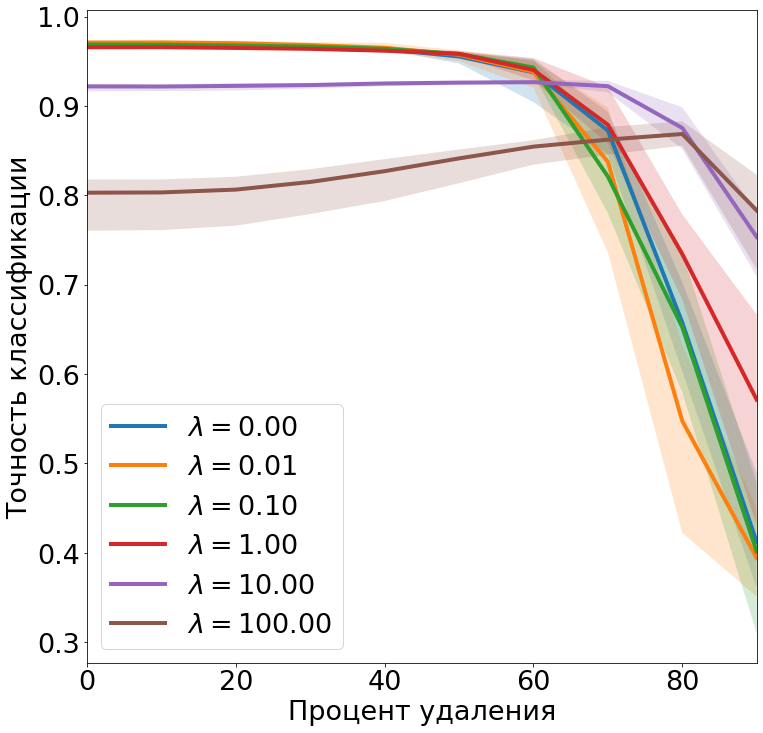

In [13]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Kernel_var')
#plt.show()


In [9]:
utils.test_acc_hyper(hnet, device, test_loader, lambda_encode, lamb)

{tensor(0.0010): 0.1014,
 tensor(0.0100): 0.9693,
 tensor(0.1000): 0.9679,
 tensor(1): 0.9668,
 tensor(10): 0.9211,
 tensor(100.): 0.7336}